In [1]:
from desc import set_device
set_device("gpu")

In [1]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list
from desc.utils import cross
from desc.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

# Import my own functions
from desc.fns_simp import (data_eval, 
                           _compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_xy,
                           surf_int)

from desc.finite_diff2 import first_derivative_t,first_derivative_z
                              #second_derivative_t,second_derivative_z,second_derivative_tz
#                             )

#from desc.derivatives import Derivative
from desc.contour_calc import contour_calc_c

from funcs import eqn_residual

Matplotlib created a temporary cache directory at /tmp/matplotlib-lp0fln3_ because the default path (/home/fcastro/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


DESC version 0.11.1+926.g8c06a1130.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 884.25 GB available memory


/home/fcastro/DESC/desc/equilibrium/initial_guess.py:226: UserWarning: Surfaces from initial guess are not nested, attempting to refine coordinates. This may take a few moments.
  warnings.warn(


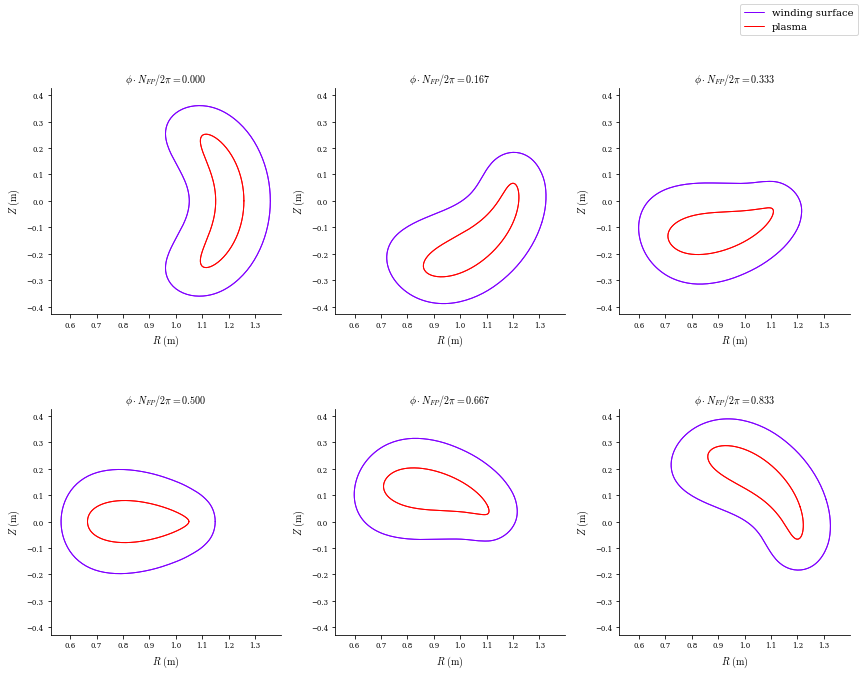

In [2]:
# Plasma surface
eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq = desc.io.load(eqname_QH)[4]

# Winding surface
surf_name = "/home/fcastro/DESC/docs/notebooks/R_Opt/opt0/surf_opt.h5"
surf_winding = load(surf_name)

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["winding surface","plasma"],theta=0,rho=np.array(1.0))
#plt.savefig("surfaces.png",dpi = 1200)

# Plot both surfaces
winding_surf = Equilibrium(surface = surf_winding) # Winding surface
#plot_comparison([winding_surf,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

In [3]:
################################################ Minimization #################################################
# Evaluation grid for the elctric potential V
kgrid = LinearGrid(M = 60, N = 60, 
                   #NFP = eq.NFP
                  )
kdata = data_eval(kgrid, winding_surf)

/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(


In [4]:
basis_M = 12
basis_N = 12

# Find surface current K_s
surface_current_field = FourierCurrentPotentialField.from_surface(surf_winding,
                                                                  M_Phi=basis_M,
                                                                  N_Phi=basis_N,
                                                                  #sym_Phi = True
                                                                 )


surface_current_field.G = np.load('G.npy')
surface_current_field.I = np.load('I.npy')
surface_current_field.Phi_mn = np.load('phi_mn.npy')

K_reg = surface_current_field.compute(["K"], grid=kgrid)["K"]
K_0 = max(dot(K_reg,K_reg)**(1/2))
K_s = (K_0)**(-1)*K_reg

phi_sv_basis = DoubleFourierSeries(M = basis_M, N = basis_N, NFP = eq.NFP, sym = "sin")

_x,_y,_z = contour_calc_c(phi_sv_basis,
                           kgrid,
                           winding_surf,
                           surface_current_field,
                           K_0)

/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 4.
 

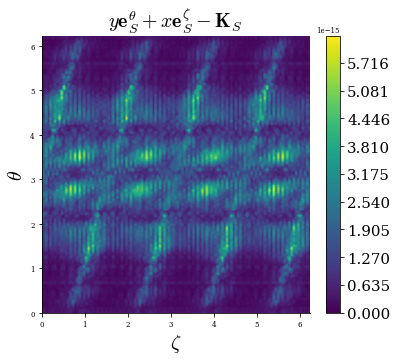

In [5]:
err = (_y*kdata["e^theta_gamma"].T + _x*kdata["e^zeta_gamma"].T).T - K_s

plot_figure(dot(err,err)**(1/2),
            kgrid,
            ''r'$ y \mathbf{e}^\theta_S + x \mathbf{e}^\zeta_S - \mathbf{K}_S $ '
           )

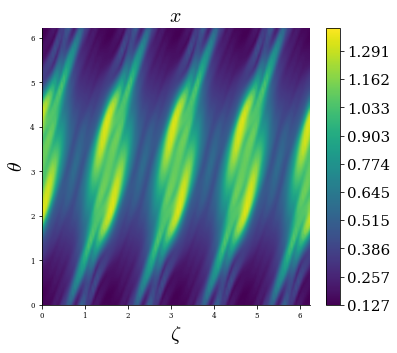

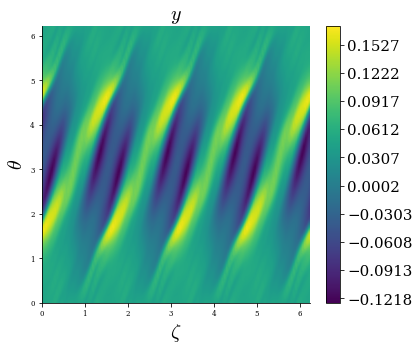

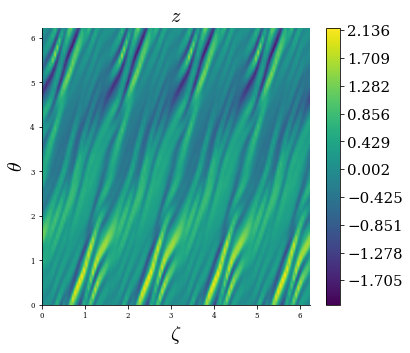

In [6]:
plot_figure(_x,
            kgrid,
            ''r'$x$ '
           )

plot_figure(_y,
            kgrid,
            ''r'$y$ '
           )

plot_figure(_z,
            kgrid,
            ''r'$z$ '
           )

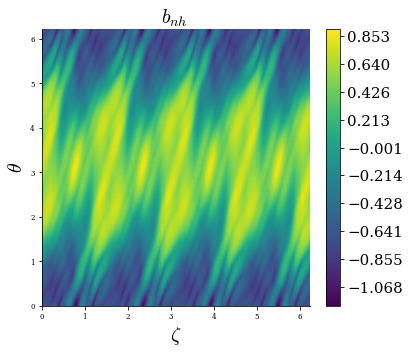

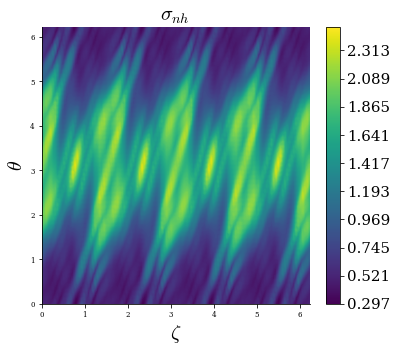

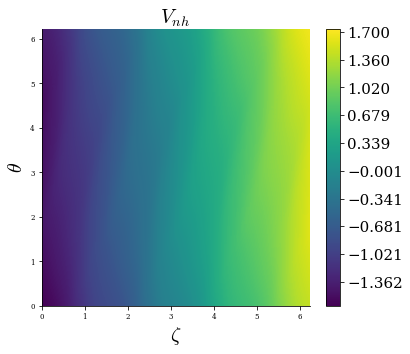

In [7]:
b0 = np.load('b_nh.npy')
s0 = jnp.exp(b0)

V0 = np.load('V_nh.npy')

plot_figure(b0,
            kgrid,
            ''r'$b_{nh}$ '
           )

plot_figure(s0,
            kgrid,
            ''r'$\sigma_{nh}$ '
           )

plot_figure(V0,
            kgrid,
            ''r'$V_{nh}$ '
           )

In [27]:
print(max(s0)/min(s0))

8.038825119993167


In [23]:
# Rescale
eps = 50
V0_mod = V0 + eps

s1 = s0*V0_mod
V1 = jnp.log(V0_mod)

print(max(s1)/min(s1))

8.44267494417112


In [28]:
s1 = s0
V1 = V0

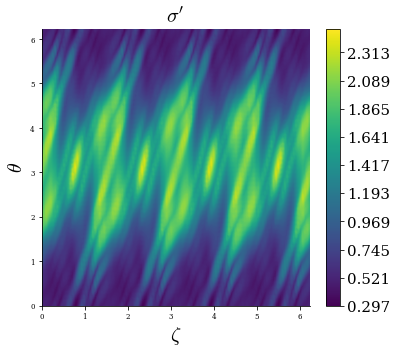

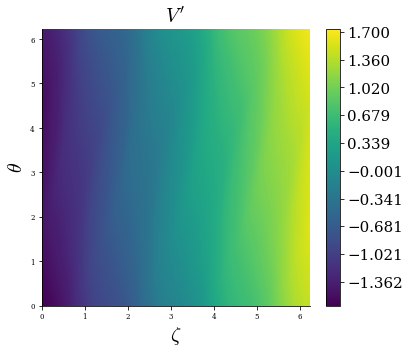

In [29]:
plot_figure(s1,
            kgrid,
            ''r'$\sigma^\prime$ '
           )

plot_figure(V1,
            kgrid,
            ''r'$V^\prime$ '
           )

In [30]:
# Transform to thickness

t_max = 15*1e-2 # 10 cm as maximum thickness for the coil
t_dist = (max(s1)**(-1)*s1)*t_max # convert from theoretical distribution to actual distribution

# Find real current density destribution
J = dot(K_reg,K_reg)**(1/2)*t_dist**(-1)

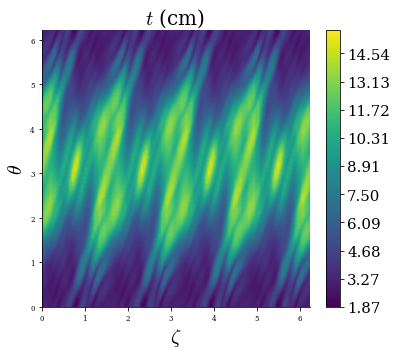

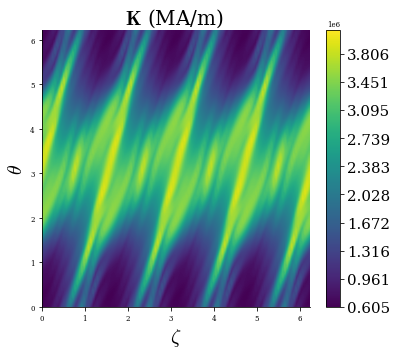

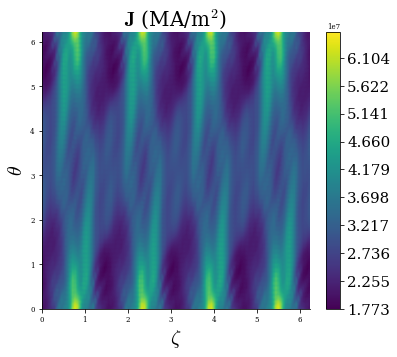

In [31]:
plot_figure(t_dist*1e2,
            kgrid,
            ''r'$t$ (cm) '
           )

plot_figure(dot(K_reg,K_reg)**(1/2),
            kgrid,
            ''r'$\mathbf{K}$ (MA/m) '
           )

plot_figure(J,
            kgrid,
            ''r'$\mathbf{J}$ (MA/m$^2$) '
           )